## Step 1: Download the base model and sample some images from it

Install all the Huggingface python packages

In [1]:
%%capture
!pip install git+https://github.com/huggingface/diffusers.git
!pip install accelerate
!pip install datasets
!pip install bitsandbytes

Set an environment variable for the base model to be fine-tuned

In [2]:
%env MODEL_NAME=stabilityai/stable-diffusion-2-1

env: MODEL_NAME=stabilityai/stable-diffusion-2-1


Define a simple function to plot a list of images returned from the model when generating

In [3]:
def plot_images(images):
    from matplotlib import pyplot as plt
    plt.figure()
    f, axarr = plt.subplots(1, len(images), figsize=(20,10))
    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

Import the relevant python libraries to load and sample from the Stable Diffusion model

In [4]:
import os
import torch

from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In this step we initialise the model and move it to the GPU (you need to choose the correct runtime on google colab to run this command). This step will also trigger the download of the model. The model is a few GB, it might take some time but it will be faster than what you expect. 😏

In [5]:
pipe = StableDiffusionPipeline.from_pretrained(os.getenv('MODEL_NAME'), torch_dtype=torch.float16)
pipe = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

We set the text prompt for generating the images and run the actual generation.

In [6]:
prompt = "isometric view of a skyscraper in the style of a city building game"
images = pipe(prompt, num_images_per_prompt=6).images

  0%|          | 0/50 [00:00<?, ?it/s]

Let's plot the images from the base model with our function:

<Figure size 640x480 with 0 Axes>

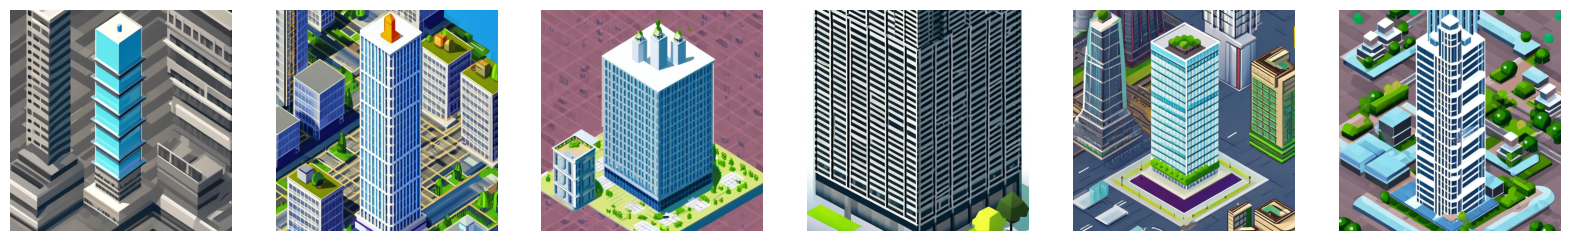

In [8]:
plot_images(images)

**IMPORTANT:** We need to free up the memory of the GPU to be able to start the actual training, let's delete the python variables and collect all the garbage using the garbage collector. Finally we use torch to empty the GPU memory

In [9]:
# Flush the GPU memory to be able to run the training
del pipe
del images

In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Step 2: Fine-tune the model

Let's clone the dataset and the hugging face code which contains the finetuning script

In [11]:
!git clone https://huggingface.co/datasets/Loulblemo/diffusion_skyscrapers_city_building
!git clone https://github.com/huggingface/diffusers.git

Cloning into 'diffusion_skyscrapers_city_building'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 134 (delta 16), reused 0 (delta 0), pack-reused 4 (from 1)
Receiving objects: 100% (134/134), 24.67 KiB | 8.22 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Filtering content: 100% (100/100), 39.91 MiB | 8.24 MiB/s, done.
Cloning into 'diffusers'...
remote: Enumerating objects: 67007, done.
remote: Counting objects: 100% (1339/1339), done.
remote: Compressing objects: 100% (640/640), done.
remote: Total 67007 (delta 880), reused 964 (delta 582), pack-reused 65668
Receiving objects: 100% (67007/67007), 47.60 MiB | 20.54 MiB/s, done.
Resolving deltas: 100% (49314/49314), done.


Set some flags for the finetuning script, the dataset to be used and the number of iterations. Since the dataset we chose is small and we want to finetune quickly using the colab free tier, let's only finetune for 50 epochs

In [12]:
%%capture
%env dataset_name=diffusion_skyscrapers_city_building
# No need to train the model for long to see meaningful results.
%env max_training_epochs = 50

Now we run the actual fine-tuning script. **IMPORTANT:** Remember if you want to train on google's free T4 GPU it's crucial to add the flag

```
--use_8bit_adam
```
We will save the model in the *city-building-model* folder


In [ ]:
# The --use_8bit_adam flag is crucial to be able to train on the T4 GPU which has only 15GB of memory
!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$dataset_name \
  --use_ema \
  --use_8bit_adam \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --mixed_precision="fp16" \
  --max_train_steps=$max_training_epochs \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="city-building-model"

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-08-01 18:10:59.516563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 18:10:59.777075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 18:10:59.845278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

## Step 3: Sample from the finetuned model

We load the new model in the GPU (this time we don't need to Download anything as the fine-tuned model has been saved locally) and generate some more images

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained('city-building-model', torch_dtype=torch.float16)
pipe = pipe.to("cuda")
prompt = "isometric view of a skyscraper in the style of a city building game"
images = pipe(prompt, num_images_per_prompt=6).images

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The new images! Hopefully the quality improved thanks to the finetuning process. You can play with the number of epochs to see how the fine-tuning process impacts the final output 💪

<Figure size 640x480 with 0 Axes>

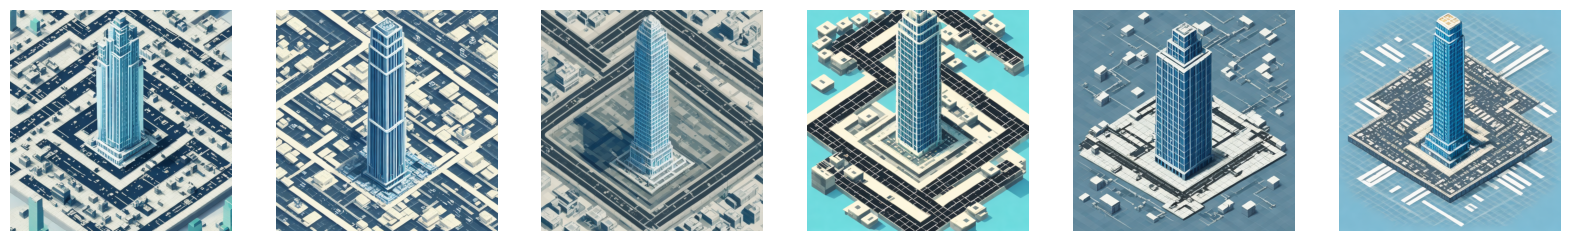

In [ ]:
plot_images(images)